In [9]:
import pandas as pd
pd.reset_option("all")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = 2000
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from tqdm import tqdm
from sklearn.model_selection import ParameterGrid,cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



In [10]:
df = pd.read_csv('final_df.csv', index_col = [0])

In [27]:
clf = LogisticRegression(C=10, penalty='l1', solver='liblinear')
feature_cols = [col for col in df.columns if col != 'target']
X = df[feature_cols]
y = df['target']
indices = [i for i, x in enumerate(X.columns) if x in ['mean_0','mean_1', 'mean_2']]
outcomes = ["draw    ", "home win", "away win"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [33]:
def profit_score(y_true, y_pred_proba, **kwargs):
    mean_index = kwargs.get('mean_index')
    original_data = kwargs.get('original_data')
    alpha = kwargs.get('alpha', np.array([0.057, 0.034, 0.037]))
#     alpha = kwargs.get('alpha', np.array([0.0, 0.0, 0.0]))
    bankroll = kwargs.get('bankroll', 10000)
    kelly_fraction = kwargs.get('kelly_fraction', 0.025)
    outcomes = ["draw    ", "home win", "away win"]

    total_profit = 0
    actual_outcomes = y_true.to_numpy()

    for i in range(len(y_pred_proba)):
        features = original_data.iloc[i]
        odds = np.array([features[mean_index[0]], features[mean_index[1]], features[mean_index[2]]])
        pred_probs = y_pred_proba[i]
        implied_probs = 1 / odds
        diffs = pred_probs - implied_probs
        j = np.argmax(diffs)

        if diffs[j] > alpha[j]:
            bet_fraction = kelly_fraction * (pred_probs[j] * odds[j] - (1 - pred_probs[j])) / (odds[j])
            bet_amount = bet_fraction * bankroll

            if actual_outcomes[i] == j:
                profit = (odds[j] - 1) * bet_amount
            else:
                profit = -bet_amount

            bankroll += profit
            total_profit += profit

#             print(f"bankroll: {bankroll:.1f} - game: {i+1} - outcome: {outcomes[actual_outcomes[i]]} - bet: {outcomes[j]} - pred prob: {pred_probs[j]:.3f} - given prob: {implied_probs[j]:.3f} - odds: {odds[j]:.3f} - bet size: {bet_amount:.3f} - profit/Loss: {profit:.3f}")

    return total_profit

profit_scorer = make_scorer(profit_score, greater_is_better=True, needs_proba=True, mean_index=indices, original_data=X_train)

In [34]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
#     'max_iter': [100,1000,10000,100000]
}

logreg = LogisticRegression()

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring=profit_scorer, cv=5, n_jobs=-1, verbose = 10)
grid_search.fit(X_train, y_train)

profit_scorer_test = make_scorer(profit_score, greater_is_better=True, needs_proba=True, mean_index=indices, original_data=X_test)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score on test set: ", profit_scorer_test(grid_search.best_estimator_, X_test, y_test))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [5.97216919e+10            nan            nan            nan
 2.16425557e+10 4.08853785e+10 3.76890201e+10 1.96293157e+10
 3.30762106e+10 3.03086899e+10 2.64136688e+10            nan
            nan            nan 2.99614176e+10 4.22015019e+10
 2.60278162e+10 1.32729879e+10 3.30330046e+10 2.98344899e+10
 2.73797724e+10            nan            nan            nan
 2.98806063e+10 2.75482781e+10 2.71453938e+10 2.84702404e+10
 3.31726026e+10 3.03715316e+10 2.57985532e+10            nan
            nan            nan 3.03065283e+10 2.57210329e+10
 1.66458113e+10 1.78965450e+10 3.30837905e+10 3.03552131e+10]
  warnings.warn(


Best Parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score on test set:  -1618.2866682171134


In [36]:
grid_search.best_score_

59721691931.62112

In [35]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.390920,0.071441,0.122293,0.017829,0.1,l1,liblinear,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",59597.909627,2.655455e+11,1.774628e+10,1.048483e+10,4.831773e+09,5.972169e+10,1.030817e+11,1
1,0.001386,0.000066,0.000000,0.000000,0.1,l1,newton-cg,"{'C': 0.1, 'penalty': 'l1', 'solver': 'newton-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,40
2,0.001396,0.000101,0.000000,0.000000,0.1,l1,lbfgs,"{'C': 0.1, 'penalty': 'l1', 'solver': 'lbfgs'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,31
3,0.001341,0.000003,0.000000,0.000000,0.1,l1,sag,"{'C': 0.1, 'penalty': 'l1', 'solver': 'sag'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
4,0.603112,0.000952,0.106768,0.001711,0.1,l1,saga,"{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}",57140.737596,7.456045e+10,1.196532e+10,1.374599e+10,7.940964e+09,2.164256e+10,2.687913e+10,24
5,0.353873,0.015213,0.106075,0.000350,0.1,l2,liblinear,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",39712.085840,1.668619e+11,1.238043e+10,2.103726e+10,4.147259e+09,4.088538e+10,6.340010e+10,3
6,1.106598,0.136558,0.106213,0.000804,0.1,l2,newton-cg,"{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-...",47613.967552,1.382600e+11,1.361114e+10,3.284486e+10,3.729062e+09,3.768902e+10,5.155864e+10,4
7,0.105238,0.002632,0.106199,0.001356,0.1,l2,lbfgs,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",36772.625743,7.552689e+10,1.155222e+10,7.542355e+09,3.525076e+09,1.962932e+10,2.821535e+10,25
8,0.368965,0.001618,0.105672,0.000395,0.1,l2,sag,"{'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}",60127.055840,1.325460e+11,1.550560e+10,1.331053e+10,4.018918e+09,3.307621e+10,5.006395e+10,7
9,0.456130,0.000889,0.106103,0.000972,0.1,l2,saga,"{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}",57270.893223,1.189292e+11,1.346224e+10,1.509988e+10,4.052083e+09,3.030869e+10,4.466929e+10,11


In [14]:
def select_features(X, y, original_data, model, alpha=np.array([0.057, 0.034, 0.037]), bankroll=10000, kelly_fraction=0.025):
    feature_sets = {}

    # RFE
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2),
                  scoring=profit_score,
                  min_features_to_select=1)
    rfecv.fit(X, y)

    selected_features_rfe = [f for f, s in zip(X.columns, rfecv.support_) if s]
    feature_sets['rfe'] = {'features': selected_features_rfe, 'score': rfecv.grid_scores_[-1]}

    # 2. Mutual Information
    mi_selector = SelectKBest(score_func=mutual_info_classif, k=10)
    mi_selector.fit(X, y)

    selected_features_mi = [f for f, s in zip(X.columns, mi_selector.get_support()) if s]
    feature_sets['mutual_info'] = {'features': selected_features_mi, 'score': mi_selector.scores_}

    # 3. Correlation
    corr_matrix = X.corr().abs()
    high_corr_vars = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.75)]
    
    # Select the features which have high correlation
    selected_features_corr = high_corr_vars
    feature_sets['correlation'] = {'features': selected_features_corr, 'score': np.mean([corr_matrix.loc[f, f] for f in high_corr_vars])}

    return feature_sets

In [23]:
def create_nn():
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=3, activation='softmax'))  # Assuming a multi-class problem with 3 classes

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

class ProbKerasClassifier(KerasClassifier):
    def predict(self, X, **kwargs):
        """Override the predict method to return class probabilities"""
        return super().predict_proba(X)

neural_net = {
    'model_type': 'Neural Network',
    'model': ProbKerasClassifier(build_fn=create_nn, verbose=0),
    'params': {'epochs': [50, 100, 200], 'batch_size': [10, 50, 100]}
}

In [16]:
model_param_dict_list = [
    {
        'model_type': 'Logistic Regression',
        'model': LogisticRegression(),
        'params': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
    },
    {
        'model_type': 'Random Forest',
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [100, 500, 1000], 'max_depth': [5, 10, 20], 'min_samples_leaf': [2, 5, 10]}
    },
    {
        'model_type': 'Support Vector Classifier',
        'model': SVC(probability=True),  # Enable probability estimates. This must be enabled prior to calling fit
        'params': {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}
    },
    {
        'model_type': 'K-Nearest Neighbors',
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 11], 'weights': ['uniform', 'distance']}
    },
    {
        'model_type': 'Decision Tree',
        'model': DecisionTreeClassifier(),
        'params': {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20], 'min_samples_leaf': [2, 5, 10]}
    },
    {
        'model_type': 'Gaussian Naive Bayes',
        'model': GaussianNB(),
        'params': {}  # GaussianNB does not have hyperparameters to tune
    },
]

In [13]:
def optimize_model(X, y, original_data, models, feature_sets, hyperparameters, alpha=np.array([0.057, 0.034, 0.037]), bankroll=10000, kelly_fraction=0.025):
    best_profit = float('-inf')
    best_model = None
    best_features = None
    best_hyperparameters = None

    for model in models:
        for features in feature_sets:
            X_subset = X[features]
            original_data_subset = original_data[features]

            for hyperparams in hyperparameters:
                # train the model with these hyperparameters
                model.set_params(**hyperparams)
                model.fit(X_subset, y)

                # calculate the profit
                profit = profit_score(model, X_subset, y, original_data_subset, alpha, bankroll, kelly_fraction)

                # if this model/feature set/hyperparameters is the best so far, save it
                if profit > best_profit:
                    best_profit = profit
                    best_model = model
                    best_features = features
                    best_hyperparameters = hyperparams

    return best_model, best_features, best_hyperparameters, best_profit

Epoch 1/10
58/58 [==============================] - 0s 6ms/step - loss: 1.0419 - accuracy: 0.4753 - val_loss: 1.0045 - val_accuracy: 0.5835
Epoch 2/10
58/58 [==============================] - 0s 3ms/step - loss: 0.9630 - accuracy: 0.6050 - val_loss: 0.9826 - val_accuracy: 0.5747
Epoch 3/10
58/58 [==============================] - 0s 3ms/step - loss: 0.9080 - accuracy: 0.6375 - val_loss: 0.9559 - val_accuracy: 0.5835
Epoch 4/10
58/58 [==============================] - 0s 3ms/step - loss: 0.8418 - accuracy: 0.6636 - val_loss: 0.9143 - val_accuracy: 0.5873
Epoch 5/10
58/58 [==============================] - 0s 3ms/step - loss: 0.7389 - accuracy: 0.6907 - val_loss: 0.9488 - val_accuracy: 0.5506
Epoch 6/10
58/58 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.7417 - val_loss: 0.9749 - val_accuracy: 0.5620
Epoch 7/10
58/58 [==============================] - 0s 3ms/step - loss: 0.5862 - accuracy: 0.7786 - val_loss: 1.0516 - val_accuracy: 0.5595
Epoch 8/10
58/58 [==

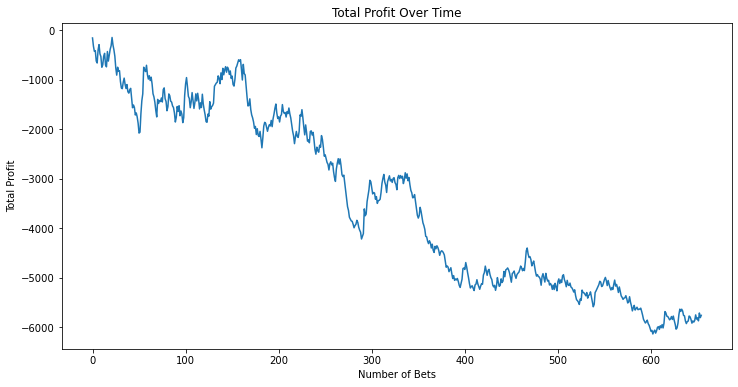

In [7]:
# Bankroll Kelly

feature_cols = [col for col in df.columns if col != 'target']
X = df[feature_cols]
y = df['target']

X_train_df, X_test_df, y_train_series, y_test_series = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)

encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train_series.values.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test_series.values.reshape(-1, 1)).toarray()

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

def predict_percentages(model, X):
    pred = model.predict(X)
    return pred / 1

predictions = predict_percentages(model, X_test)

profits = []
total_profit = 0
bets_odds = []
bets_count = 0
actual_outcomes = np.argmax(y_test, axis=1)
alpha = np.array([0.057, 0.034, 0.037])
# alpha = np.array([0.,0.,0.])

bankroll = 10000
kelly_fraction = 0.025
outcomes = ["draw    ", "home win", "away win"]

bets_won = []
bets_lost = []

odds_won = []
odds_lost = []

for i in range(len(X_test_df)):
    idx = X_test_df.index[i]
    odds = df.loc[idx, ['mean_0', 'mean_1', 'mean_2']].values
    pred_probs = predictions[i]
    implied_probs = 1 / odds

    diffs = pred_probs - implied_probs
    j = np.argmax(diffs)

    if diffs[j] > alpha[j]:  # if the largest difference is greater than alpha
        bet_fraction = kelly_fraction * (pred_probs[j] * odds[j] - (1 - pred_probs[j])) / (odds[j])
        bet_amount = bet_fraction * bankroll
        bets_odds.append(odds[j])
        bets_count += 1
        actual_outcome = actual_outcomes[i]

        if actual_outcome == j:
            profit = (odds[j] - 1) * bet_amount
            bankroll += profit
            bets_won.append(bet_amount)
            odds_won.append(odds[j])
#             print(f"W {bankroll:.1f} - SD: {df.loc[idx, ['score_diff']][0]}\f - game: {i+1}\f outcome: {outcomes[actual_outcome]}\f - bet: {outcomes[j]}\f - pred prob: {pred_probs[j]:.3f}\f - given prob: {implied_probs[j]:.3f}\f - odds {odds[j]:.3f}\f - bet size: {bet_amount:.3f}\f - profit/loss: {profit:.3f}")
        else:
            profit = -bet_amount
            bankroll += profit
            bets_lost.append(bet_amount)
            odds_lost.append(odds[j])
#             print(f"L {bankroll:.1f} - SD: {df.loc[idx, ['score_diff']][0]}\f - game: {i+1}\f outcome: {outcomes[actual_outcome]}\f - bet: {outcomes[j]}\f - pred prob: {pred_probs[j]:.3f}\f - given prob: {implied_probs[j]:.3f}\f - odds {odds[j]:.3f}\f - bet size: {bet_amount:.3f}\f - profit/loss: {profit:.3f}")

        profits.append(profit)
        total_profit += profit

num_wins = len(bets_won)
win_rate = num_wins / bets_count if bets_count > 0 else 0

print('Total profit:', total_profit)
print('Average bet odds:', np.mean(bets_odds))
print('Number of bets placed:', bets_count)
print('Number of bets won:', num_wins)
print('Win rate:', f'{win_rate*100:.2f}%')
print('Average bet size when won:', np.mean(bets_won))
print('Average bet size when lost:', np.mean(bets_lost))
print('Average odds when won:', np.mean(odds_won))
print('Average odds when lost:', np.mean(odds_lost))


plt.figure(figsize=(12,6))
plt.plot(np.cumsum(profits))
plt.title('Total Profit Over Time')
plt.xlabel('Number of Bets')
plt.ylabel('Total Profit')
plt.show()